# Práctico librería implicit - ALS y BPR

Clase: IIC3633 Sistemas Recomendadores, PUC Chile

En este práctico vamos a utilizar la biblioteca de Python [implicit](https://implicit.readthedocs.io/en/latest/quickstart.html) para recomendación utilizando ALS y BPR. 


In [1]:
!curl -L -o "u2.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"
!curl -L -o "u2.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    360      0 --:--:--  0:00:01 --:--:--   360
100 1546k  100 1546k    0     0   880k      0  0:00:01  0:00:01 --:--:-- 2288k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    695      0 --:--:-- --:--:-- --:--:--   694
100  385k  100  385k    0     0   329k      0  0:00:01  0:00:01 --:--:--  329k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    663      0 --:--:-- --:--:-- --:--:--   663
100  230k  100  230k    0     0   205k      0  0:00:01  0:00:01 --:--:-- 75.1M


In [2]:
!pip3 install implicit --upgrade

     |████████████████████████████████| 1.1MB 2.8MB/s 
  Created wheel for implicit: filename=implicit-0.4.2-cp36-cp36m-linux_x86_64.whl size=3420113 sha256=2634c5ca5d0041a3583255fe2916b6c9dec8cbe227d67350238fffcc5931dfc8
  Stored in directory: /root/.cache/pip/wheels/1b/48/b1/1aebe3acc3afb5589e72d3e7c3ffc3f637dc4721c1a974dff7
Successfully built implicit


In [45]:
import pandas as pd
import numpy as np
import implicit
import seaborn as sns
import scipy.sparse as sparse
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style="whitegrid")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [5]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv('u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)

# rating >= 3 , relevante (1) y rating menor a 3 es no relevante (0)
df_train.rating = [1 if x >=3 else 0 for x in df_train.rating ]

In [6]:
df_train.head()

,userid,itemid,rating,timestamp
0,1,3,1,878542960
1,1,4,1,876893119
2,1,5,1,889751712
3,1,6,1,887431973
4,1,7,1,875071561


In [8]:
# Cargamos el dataset con los items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None, 
                        encoding='latin-1')

In [9]:
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [11]:
# Cargamos el dataset de testing
df_test = pd.read_csv('u2.test',
                      sep='\t',
                      names=['userid', 'itemid', 'rating', 'timestamp'],
                      header=None)


# rating >= 3 es relevante (1) y rating menor a 3 es no relevante (0) 
df_test.rating = [1 if x >=3 else 0 for x in df_test.rating ]


user_items_test = {}

for row in df_test.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []
        
    user_items_test[row[1]].append(row[2])

In [ ]:
df_test.head()

### Métricas

In [25]:
# Definicion de métricas (No editar)
# Obtenido de https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])
  
def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

### Preprocesamiento de los datos a formato sparse

In [18]:
user_items = {}
itemset = set()

for row in df_train.itertuples():
    if row[1] not in user_items:
        user_items[row[1]] = []
        
    user_items[row[1]].append(row[2])
    itemset.add(row[2])

itemset = np.sort(list(itemset))

sparse_matrix = np.zeros((len(user_items), len(itemset)))

for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)
    
matrix = sparse.csr_matrix(sparse_matrix.T)

user_ids = {key: i for i, key in enumerate(user_items.keys())}
user_item_matrix = matrix.T.tocsr()


In [26]:
def evaluate_model(model, n):
  mean_map = 0.
  mean_ndcg = 0.
  for u in user_items_test.keys():
    rec = [t[0] for t in model.recommend(u, user_item_matrix, n)]
    rel_vector = [np.isin(user_items_test[u], rec, assume_unique=True).astype(int)]
    mean_map += mean_average_precision(rel_vector)
    mean_ndcg += ndcg_at_k(rel_vector, n)

  mean_map /= len(user_items_test)
  mean_ndcg /= len(user_items_test)
  
  return mean_map, mean_ndcg

In [27]:
def show_recommendations(model, user, n):
  recommendations = [t[0] for t in model.recommend(user, user_item_matrix, n)]
  return df_items.loc[recommendations]['title']

In [28]:
def show_similar_movies(model, item, n=10):
  sim_items = [t[0] for t in model.similar_items(item, n)]
  return df_items.loc[sim_items]['title']

## ALS (Implicit Feedback)

**Pregunta 1:** Explique brevemente cómo funciona el algoritmo ALS.

**Respuesta:** Dada una matriz $R$ de usuarios e items, el algoritmo ALS lo que hace es una factorización matricial de la forma $U^{T} V$, donde los elementos de $U$ y $V$ son hallados para minimizar el error cuadrático medio con respecto a $R$.  Lo especial que tiene esta factorización (y el motivo por el cual se denomina Alternating) es que en su proceso de optimización con descenso de gradiente va alternando los updates entre $U$ y $V$.


In [37]:
# Definimos y entrenamos el modelo con optimización ALS
model_als = implicit.als.AlternatingLeastSquares(factors=100, iterations=10, use_gpu=False)
model_als.fit(matrix)

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [38]:
show_recommendations(model_als, user=77, n=10)

movieid
258                                       Contact (1997)
256    When the Cats Away (Chacun cherche son chat) (...
248                           Grosse Pointe Blank (1997)
864                           My Fellow Americans (1996)
240               Beavis and Butt-head Do America (1996)
292                                      Rosewood (1997)
754                                    Red Corner (1997)
409                                          Jack (1996)
357               One Flew Over the Cuckoo's Nest (1975)
813                         Celluloid Closet, The (1995)
Name: title, dtype: object

In [39]:
maprec, ndcg = evaluate_model(model_als, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.06639467278568434
ndcg: 0.333843797856049


**Pregunta 2:** Pruebe distintos valores para los parámetros de ALS y muestre gráficos de cómo se ven afectadas las métricas recién mostradas.

In [42]:
factor_values = [50, 100, 150, 200, 250]
maprec_values = []
ndcg_values = [] 

for f in factor_values:
  model_als = implicit.als.AlternatingLeastSquares(factors=f, iterations=10, use_gpu=False)
  model_als.fit(matrix)
  maprec, ndcg = evaluate_model(model_als, n=10)
  print('map: {}\nndcg: {}'.format(maprec, ndcg))
  maprec_values.append(maprec)
  ndcg_values.append(ndcg)


map: 0.06581180111812246
ndcg: 0.33843797856049007



map: 0.0641216666331864
ndcg: 0.32465543644716693



map: 0.05361635895987944
ndcg: 0.333843797856049



map: 0.04724566684852561
ndcg: 0.3093415007656968



map: 0.04182176499303805
ndcg: 0.28637059724349156


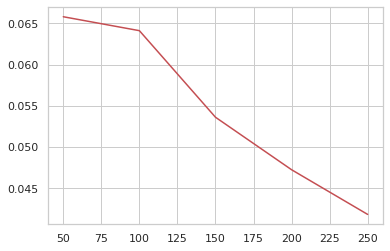

In [46]:
plt.plot(factor_values, maprec_values, 'r-')
plt.show()

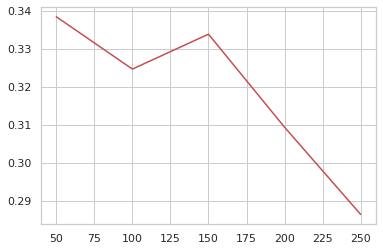

In [47]:
plt.plot(factor_values, ndcg_values, 'r-')
plt.show()

Se observa que a medida que aumentamos los factores latentes, los modelos son menos precisos pues las métricas empeoran.


In [50]:
iteration_values = [10, 20, 30, 40, 50, 100]
maprec_values = []
ndcg_values = [] 

for it in iteration_values:
  model_als = implicit.als.AlternatingLeastSquares(factors=100, iterations=it, use_gpu=False)
  model_als.fit(matrix)
  maprec, ndcg = evaluate_model(model_als, n=10)
  print('map: {}\nndcg: {}'.format(maprec, ndcg))
  maprec_values.append(maprec)
  ndcg_values.append(ndcg)


map: 0.06147201276847862
ndcg: 0.33078101071975496



map: 0.06086636540577773
ndcg: 0.333843797856049



map: 0.06131129578960781
ndcg: 0.327718223583461



map: 0.06082838236476452
ndcg: 0.33996937212863704



map: 0.05913349488429994
ndcg: 0.33078101071975496



map: 0.061464342793960965
ndcg: 0.33537519142419603


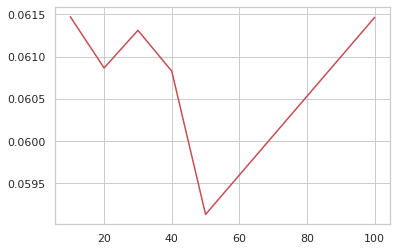

In [51]:
plt.plot(iteration_values, maprec_values, 'r-')
plt.show()

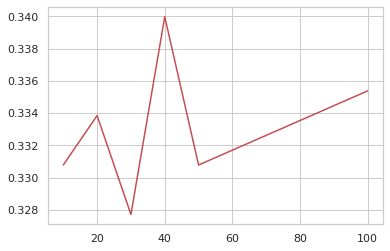

In [53]:
plt.plot(iteration_values, ndcg_values, 'r-')
plt.show()

Aquí observamos que al principio los resultados son peores pues las métricas de rendimiento descienden en valor, sin embargo, aparentemente, si intentamos más iteraciones el modelo obtiene mejores rendimientos, aunque depende de con qué métrica.

## BPR

**Pregunta 3:** Explique con sus palabras la intuición del framework BPR.

BPR no es un modelo como tal, si no que provee de dos cosas: una función de pérdida que denominan BPR-Opt, además de un mecanismo de aprendizaje. Este "sistema" surje de considerar tripletas $(u,i,j)$ en lugar de pares $(u,i)$ con la finalidad de ordenar las preferencias para un usuario. Lo que se busca maximizar es la cantidad de predicciones correctas con respecto a ese orden de preferencia. El mecanismo de aprendizaje es un descenso de gradiente estocástico con bootstraping en lugar de iterar sobre todo el conjunto.  

In [32]:
# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=400, iterations=40, use_gpu=False)
model_bpr.fit(matrix)

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [54]:
show_recommendations(model_bpr, user=77, n=10)

movieid
257              Men in Black (1997)
299                   Hoodlum (1997)
676             Crucible, The (1996)
301                  In & Out (1997)
327                  Cop Land (1997)
285            Secrets & Lies (1996)
746               Real Genius (1985)
332            Kiss the Girls (1997)
267                          unknown
244    Smilla's Sense of Snow (1997)
Name: title, dtype: object

In [56]:
show_similar_movies(model_bpr, item=171, n=10)

movieid
171                Delicatessen (1991)
209          This Is Spinal Tap (1984)
203                  Unforgiven (1992)
233                 Under Siege (1992)
194                  Sting, The (1973)
95                      Aladdin (1992)
201                Evil Dead II (1987)
78                   Free Willy (1993)
172    Empire Strikes Back, The (1980)
21       Muppet Treasure Island (1996)
Name: title, dtype: object

In [57]:
maprec, ndcg = evaluate_model(model_bpr, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.05364008961880157
ndcg: 0.3552833078101072


**Pregunta 4:** Pruebe distintos valores para los parámetros de BPR y muestre gráficos de cómo se ven afectadas las métricas de ranking (nDCG@10 y MAP) recién mostradas.

In [62]:
factor_values = [50, 100, 200, 300, 400, 500, 600]
maprec_values = []
ndcg_values = [] 

for f in factor_values:
    model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=f, iterations=40, use_gpu=False)
    model_bpr.fit(matrix)
    maprec, ndcg = evaluate_model(model_bpr, n=10)
    print('map: {}\nndcg: {}'.format(maprec, ndcg))
    maprec_values.append(maprec)
    ndcg_values.append(ndcg)


map: 0.04032928707212119
ndcg: 0.3231240428790199



map: 0.04441285115510216
ndcg: 0.33078101071975496



map: 0.05858603644586369
ndcg: 0.36294027565084225



map: 0.053407609504692574
ndcg: 0.3552833078101072



map: 0.05020421778943853
ndcg: 0.34150076569678406



map: 0.054286666134658025
ndcg: 0.35068912710566613



map: 0.05063405005658184
ndcg: 0.3552833078101072


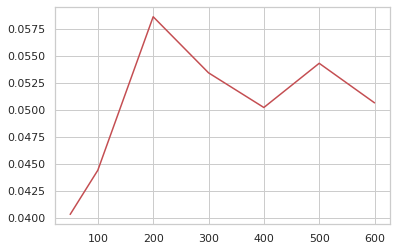

In [63]:
plt.plot(factor_values, maprec_values, 'r-')
plt.show()

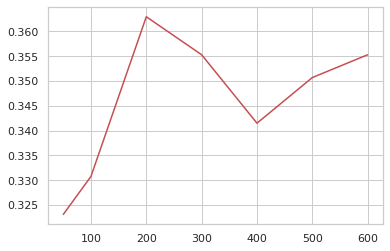

In [65]:
plt.plot(factor_values, ndcg_values, 'r-')
plt.show()

Todo parece indicar que el mejor modelo es el que considera 200 factores


In [68]:
# Ahora consideremos distintas cantidades de iteraciones con los 200 factores

iteration_values = [20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
maprec_values = []
ndcg_values = [] 

for it in iteration_values:
    model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=200, iterations=it, use_gpu=False)
    model_bpr.fit(matrix)
    maprec, ndcg = evaluate_model(model_bpr, n=10)
    print('map: {}\nndcg: {}'.format(maprec, ndcg))
    maprec_values.append(maprec)
    ndcg_values.append(ndcg)



map: 0.04955252726278672
ndcg: 0.33843797856049007



map: 0.05367860234772425
ndcg: 0.33843797856049007



map: 0.061714348264591004
ndcg: 0.3537519142419602



map: 0.04643952338527874
ndcg: 0.3093415007656968



map: 0.04951239680895801
ndcg: 0.30474732006125577



map: 0.04341800034985344
ndcg: 0.2894333843797856



map: 0.043038793080588875
ndcg: 0.2725880551301684



map: 0.04010840189040851
ndcg: 0.2664624808575804



map: 0.03685994066335604
ndcg: 0.26339969372128635



map: 0.030593952691503376
ndcg: 0.25880551301684535


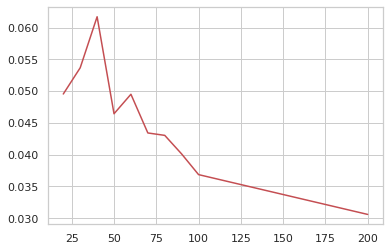

In [71]:
plt.plot(iteration_values, maprec_values, 'r-')
plt.show()

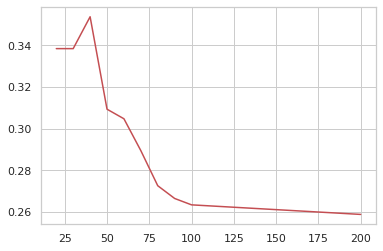

In [72]:
plt.plot(iteration_values, ndcg_values, 'r-')
plt.show()

Se observa que el peak performance se obtiene con 200 factores y 40 iteraciones :)
